In [159]:
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
elon_df = pd.concat([
    pd.read_csv('data/elon/2019.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2020.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2021.csv', index_col='id'),
])[['tweet', 'date']]
elon_df.rename(columns={'tweet': 'text'}, inplace=True)
elon_df['datetime'] = pd.to_datetime(elon_df['date'])
elon_df['date'] = pd.to_datetime(elon_df['datetime'].dt.date)
elon_df = elon_df.query("date >= '2019-01-01' and date < '2022-01-01'")
elon_df.drop_duplicates(inplace=True)
elon_df.head()

,text,date,datetime
id,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09


In [45]:
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9377 entries, 1211071324518531072 to 1344810193952014336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      9377 non-null   object        
 1   date      9377 non-null   datetime64[ns]
 2   datetime  9377 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 293.0+ KB


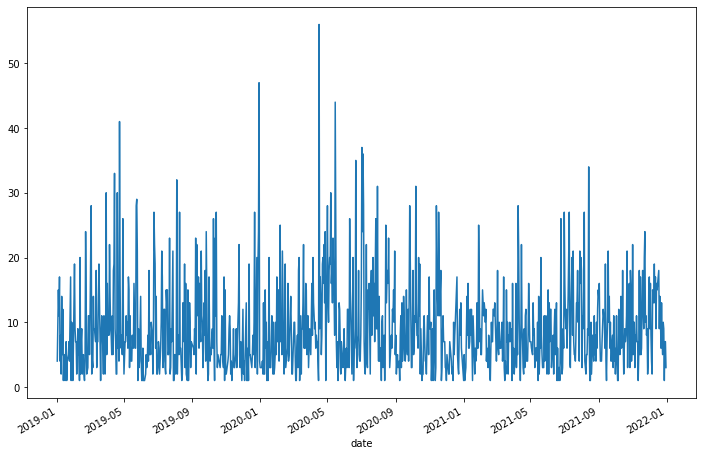

In [46]:
elon_df.groupby('date')['text'].count().plot(figsize=(12, 8));

In [48]:
elon_df['text'].head()

id
1211071324518531072    @Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...
1211069054779301894    @austinbarnard45 @tjq1190 @tyger_cyber @fawful...
1211064937004589056    @IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...
1211054942192119808    @tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...
1211051740562366464                             @geofficient Pretty much
Name: text, dtype: object

In [58]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub(r'&\w+;', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [59]:
empty_tweets = (
    elon_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(elon_df[empty_tweets].shape)
elon_df[empty_tweets]

(4, 3)


,text,date,datetime
id,,,
1132183974103535616,💨 &amp; 🌌 https://t.co/wWl7nEh98W,2019-05-25,2019-05-25 07:17:49
1112427303013736448,@yungjake &amp; @bloodpop,2019-03-31,2019-03-31 18:51:51
1215577256694710272,@Ye4bu @AyyAnge 🔥 &amp; ⚡️,2020-01-10,2020-01-10 10:12:56
1401096409428934659,💦🚀 –&gt; 🌙,2021-06-05,2021-06-05 00:00:00


In [60]:
elon_df = elon_df[~empty_tweets]
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 1211071324518531072 to 1344810193952014336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      8645 non-null   object        
 1   date      8645 non-null   datetime64[ns]
 2   datetime  8645 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 270.2+ KB


In [61]:
tweet_words = collections.Counter()
elon_df.text.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v not in set(stop_words)]).apply(tweet_words.update)
len(tweet_words), tweet_words.most_common(50)

(9651,
 [('tesla', 661),
  ('yes', 386),
  ('great', 327),
  ('good', 295),
  ('much', 288),
  ('would', 283),
  ('like', 252),
  ('high', 240),
  ('starship', 225),
  ('haha', 222),
  ('true', 216),
  ('time', 214),
  ('one', 208),
  ('probably', 197),
  ('sure', 188),
  ('also', 186),
  ('yeah', 186),
  ('make', 185),
  ('production', 183),
  ('year', 183),
  ('work', 176),
  ('next', 172),
  ('many', 170),
  ('spacex', 167),
  ('3', 164),
  ('car', 164),
  ('soon', 164),
  ('exactly', 162),
  ('new', 159),
  ('people', 158),
  ('2', 157),
  ('need', 153),
  ('get', 152),
  ('hard', 150),
  ('mars', 150),
  ('even', 148),
  ('cars', 145),
  ('coming', 142),
  ('engine', 141),
  ('lot', 140),
  ('1', 140),
  ('years', 140),
  ('team', 139),
  ('first', 136),
  ('long', 132),
  ('better', 132),
  ('10', 131),
  ('way', 131),
  ('still', 131),
  ('maybe', 129)])

In [64]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=1000,
    preprocessor=text_preprocessor
)
tfidf_vectorizer.fit(elon_df.text)
len(tfidf_vectorizer.vocabulary_)

1000

In [65]:
text_tfidf = tfidf_vectorizer.transform(elon_df.text).toarray()

In [66]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_tfidf)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_tfidf)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_tfidf)
print('UMAP(cosine) done!')

PCA done!


/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP done!
UMAP(cosine) done!
CPU times: user 1min 26s, sys: 6.54 s, total: 1min 33s
Wall time: 1min 9s


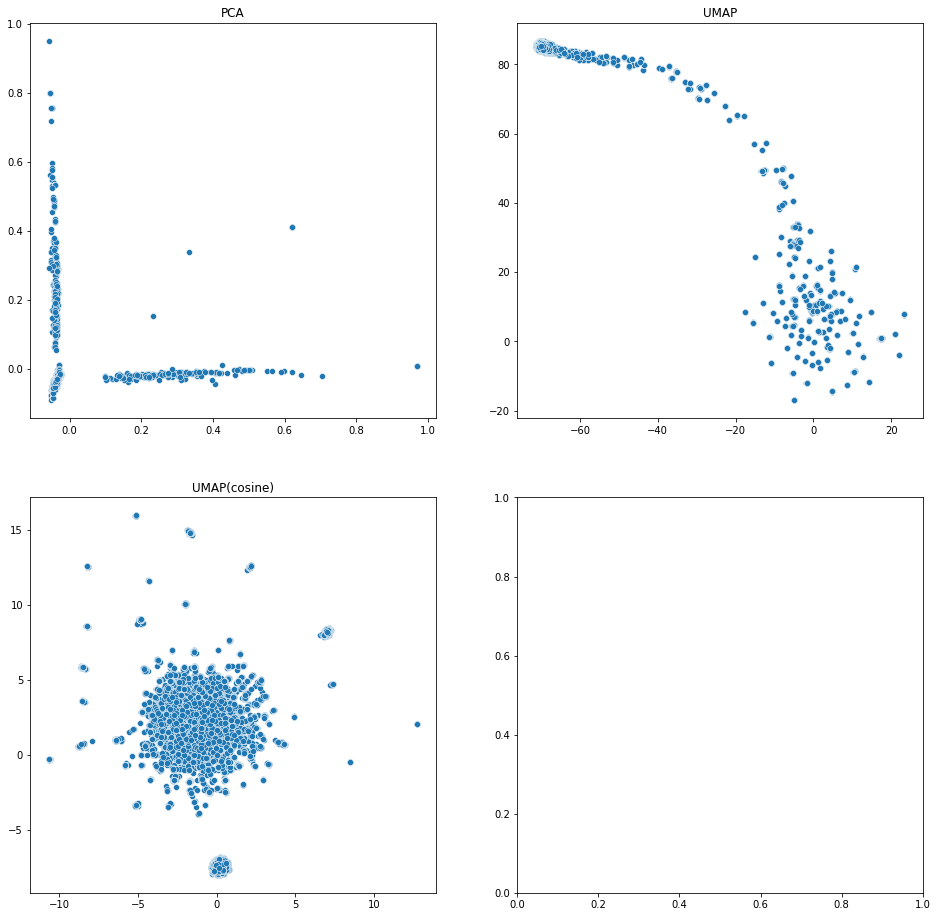

In [67]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [72]:
K = list(range(1, 16))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_tfidf)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_tfidf, kmeans.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.99s/it]


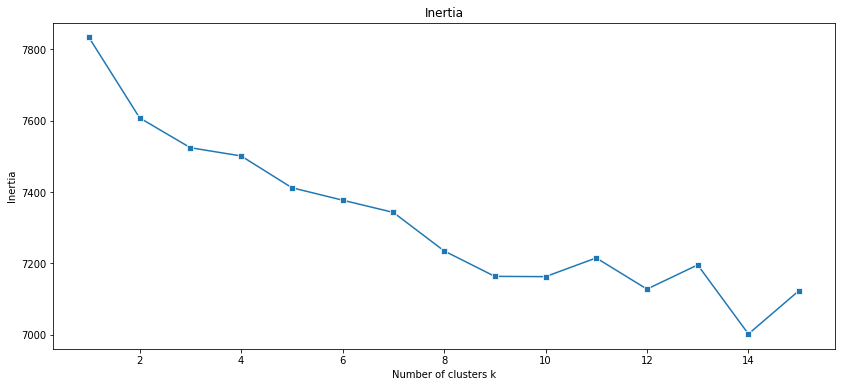

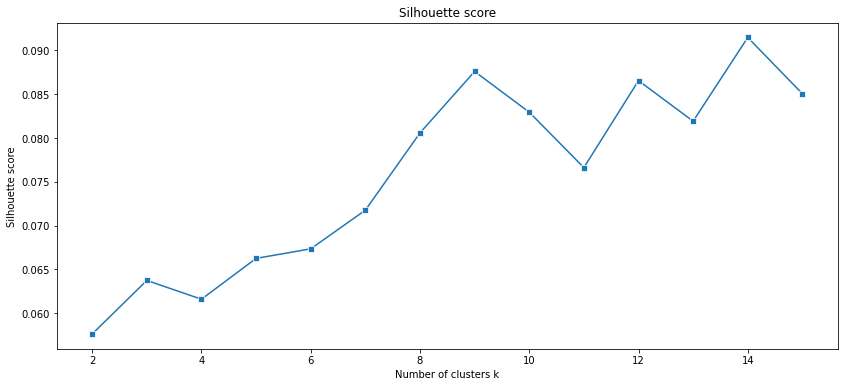

In [73]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [74]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

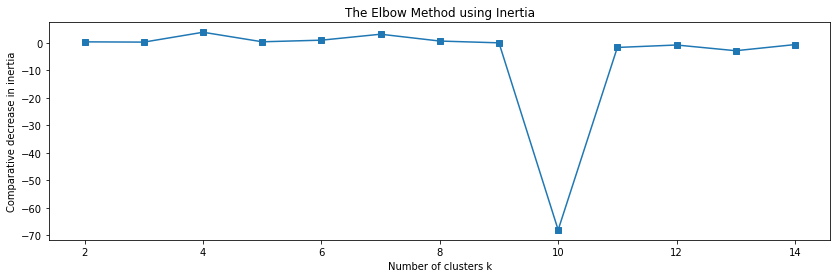

In [75]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys()), list(d.values()), marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [76]:
kmeans = KMeans(
    n_clusters=2,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_tfidf)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

2


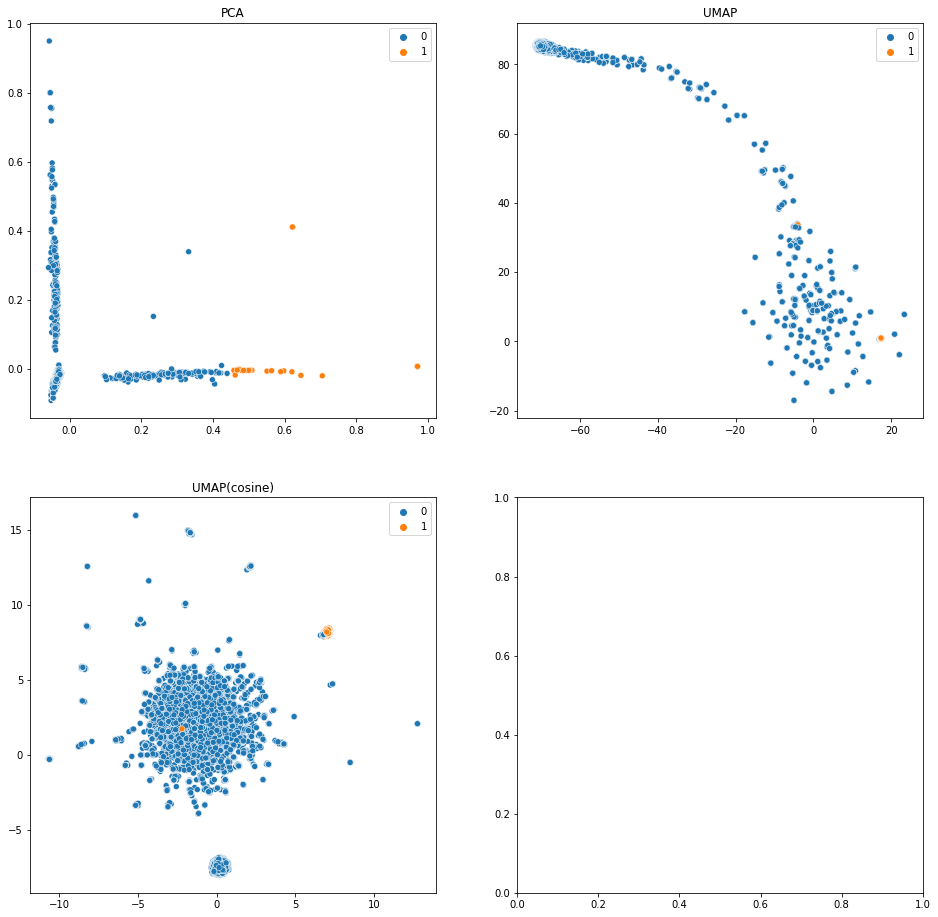

In [77]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [78]:
elon_df['cluster'] = clusters

In [79]:
elon_df.groupby('cluster')['cluster'].count()

cluster
0    8395
1     250
Name: cluster, dtype: int64

In [196]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v in tfidf_vectorizer.vocabulary_]).apply(words_counter.update)
    return words_counter.most_common(n)

In [81]:
elon_df.query('cluster == 0').head(10)

,text,date,datetime,cluster
id,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59,0
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57,0
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36,0
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53,0
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09,0
1211030324660051968,@annerajb @justpaulinelol Federal,2019-12-28,2019-12-28 21:05:03,0
1211030194787700736,@justpaulinelol @annerajb Probably 2021. Depen...,2019-12-28,2019-12-28 21:04:32,0
1211029491188948992,@annerajb Hopefully working in Caribbean by en...,2019-12-28,2019-12-28 21:01:45,0
1211010494695391232,@waitbutwhy @Kurz_Gesagt Maximizing conversion...,2019-12-28,2019-12-28 19:46:16,0


In [82]:
print_top_n_words(elon_df.query('cluster == 0').text)

[('tesla', 660),
 ('great', 327),
 ('good', 294),
 ('much', 288),
 ('would', 283),
 ('like', 252),
 ('high', 240),
 ('starship', 225),
 ('haha', 218),
 ('true', 216),
 ('time', 214),
 ('one', 208),
 ('probably', 196),
 ('sure', 188),
 ('also', 186),
 ('yeah', 186),
 ('make', 185),
 ('production', 183),
 ('year', 183),
 ('work', 176),
 ('next', 172),
 ('many', 170),
 ('spacex', 167),
 ('car', 164),
 ('soon', 164)]

In [84]:
elon_df.query('cluster == 1').head(10)

,text,date,datetime,cluster
id,,,,
1210777492027363328,"@TheAssassin_95 Yes, but it’s too secret",2019-12-28,2019-12-28 04:20:23,1
1209536537794359297,@Erdayastronaut @Tesla Yes,2019-12-24,2019-12-24 18:09:17,1
1208841343440568320,@youfoundalec @EV_Stevee @teslaownersSV @cgpgr...,2019-12-22,2019-12-22 20:06:50,1
1208832682693541888,@RenataKonkoly Yes 🤣♥️,2019-12-22,2019-12-22 19:32:25,1
1208468535292203008,@teslaownersSV Yes,2019-12-21,2019-12-21 19:25:25,1
1207131698468544512,"@acevedo_lex @AlexSibila @Tesla Yes, probably ...",2019-12-18,2019-12-18 02:53:18,1
1205806734960234496,@Kristennetten Yes,2019-12-14,2019-12-14 11:08:23,1
1201950417145327616,@Ragnvaldr1 Yes,2019-12-03,2019-12-03 19:44:45,1
1198347877237420032,@somepitch Yes,2019-11-23,2019-11-23 21:09:32,1


In [85]:
print_top_n_words(elon_df.query('cluster == 1').text)

[('yes', 250),
 ('haha', 4),
 ('probably', 1),
 ('irony', 1),
 ('months', 1),
 ('full', 1),
 ('slightly', 1),
 ('play', 1),
 ('good', 1),
 ('called', 1),
 ('tip', 1),
 ('tesla', 1),
 ('given', 1),
 ('improvement', 1),
 ('insane', 1),
 ('even', 1),
 ('lot', 1),
 ('mars', 1),
 ('unfortunately', 1),
 ('long', 1)]

In [86]:
elon_df.query('cluster == 2').head(10)

,text,date,datetime,cluster
id,,,,


In [87]:
print_top_n_words(elon_df.query('cluster == 2').text)

[]

In [137]:
EPS = np.linspace(0.01, 1.5, 101)

silhouette = {}
clusters = {}

for eps in tqdm(EPS):
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_tfidf) # metric='cosine' checked
    clusters[eps] = len(set(dbscan.labels_)) - 1
    # print(set(dbscan.labels_))
    if len(set(dbscan.labels_)) > 1:
        # print(eps, set(dbscan.labels_))
        silhouette[eps] = silhouette_score(text_tfidf, dbscan.labels_)
# print(silhouette

100%|██████████████████████████████████████████████████████████████████| 101/101 [04:50<00:00,  2.88s/it]


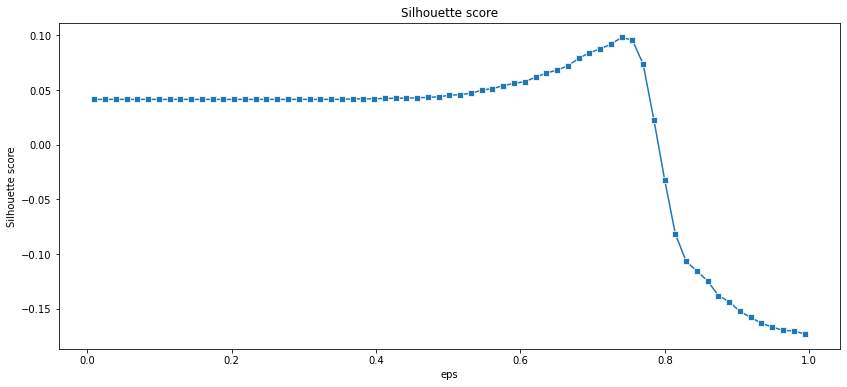

In [138]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

plt.title('Silhouette score')
plt.xlabel('eps')
plt.ylabel('Silhouette score')

plt.show()

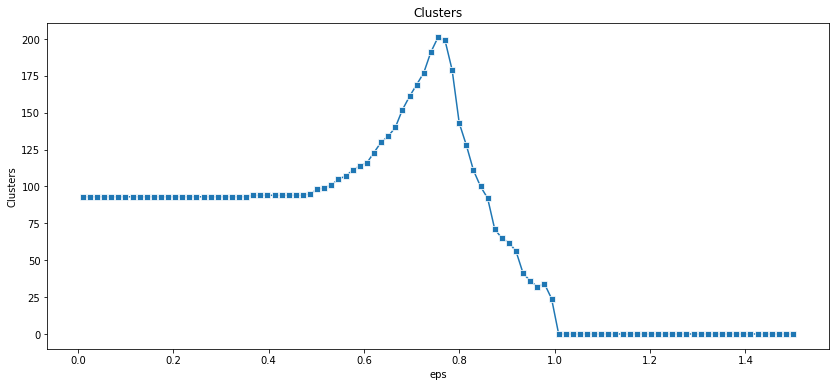

In [139]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

plt.title('Clusters')
plt.xlabel('eps')
plt.ylabel('Clusters')

plt.show()

In [140]:
best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_eps

0.7401

In [141]:
dbscan = DBSCAN(eps=best_eps, n_jobs=-1) # metric='cosine' checked
elon_df['clusters_dbsacn'] = dbscan.fit_predict(text_tfidf)

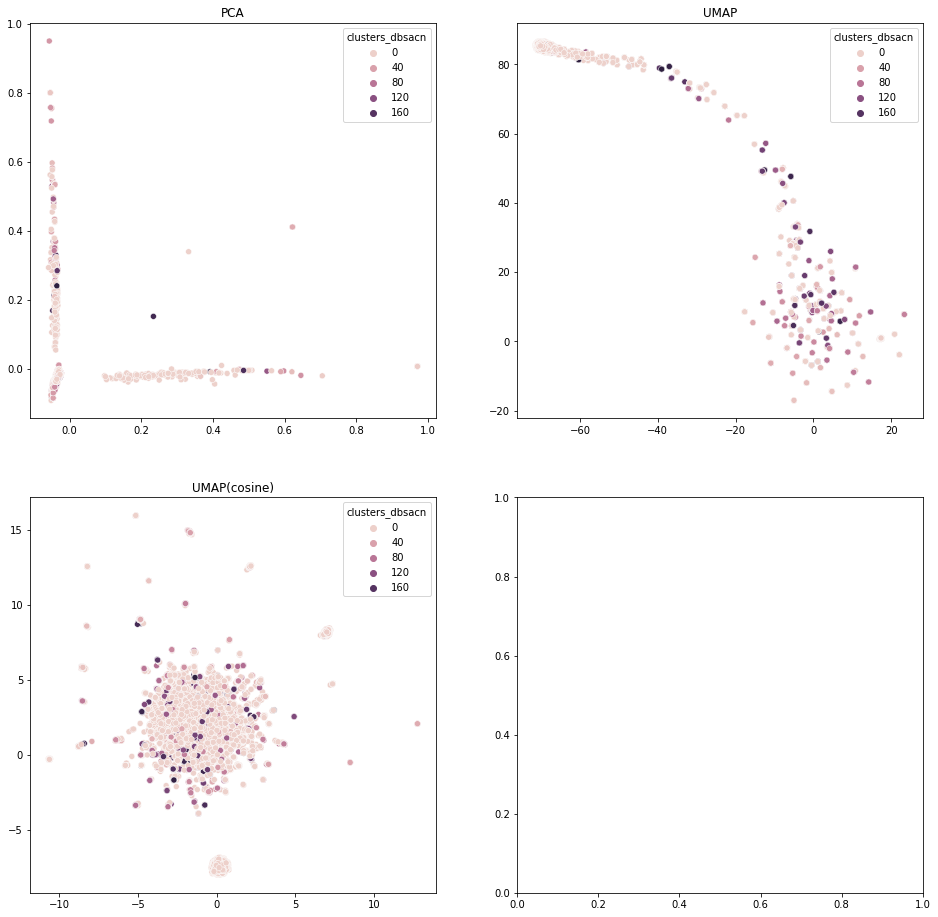

In [142]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['clusters_dbsacn']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['clusters_dbsacn']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['clusters_dbsacn']);

In [143]:
elon_df.groupby('clusters_dbsacn')['clusters_dbsacn'].count()

clusters_dbsacn
-1      5444
 0        36
 1       748
 2       230
 3         7
        ... 
 186      11
 187       5
 188       5
 189       5
 190       5
Name: clusters_dbsacn, Length: 192, dtype: int64

In [158]:
cluster = 3

print(print_top_n_words(elon_df.query(f'clusters_dbsacn == {cluster}').text))
elon_df.query(f'clusters_dbsacn == {cluster}').head(10)

[('would', 8), ('second', 1)]


,text,date,datetime,cluster,clusters_dbsacn
id,,,,,
1210774833681719296,@Salo4201 That would be a fringe benefit 🤣🤣,2019-12-28,2019-12-28 04:09:50,0,3
1208679393096130560,Pre VFX cut would be $$$$,2019-12-22,2019-12-22 09:23:18,0,3
1157808672648683520,@SIMOZT1 @justpaulinelol @EvaFoxU @SpaceX I wo...,2019-08-04,2019-08-04 00:21:13,0,3
1325404393076887557,@RenataKonkoly @SpaceNews_Inc It would appear ...,2020-11-08,2020-11-08 11:46:46,0,3
1258519585260580864,@Godmiller1 @Johnnaaaaaaaaaa @EvaFoxU @Tesla W...,2020-05-07,2020-05-07 22:10:25,0,3
1465413718976643079,@VikingRocket @WholeMarsBlog Variable gain (st...,2021-11-30,2021-11-30 00:00:00,0,3
1440747919108296708,@SueOrigin @SciGuySpace That would break the N...,2021-09-22,2021-09-22 00:00:00,0,3


In [220]:
K = list(range(2, 251))

silhouette = {}

for k in tqdm(K):
    aggl = AgglomerativeClustering(n_clusters=k).fit(text_tfidf)
    silhouette[k] = silhouette_score(text_tfidf, aggl.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████| 249/249 [1:38:16<00:00, 23.68s/it]


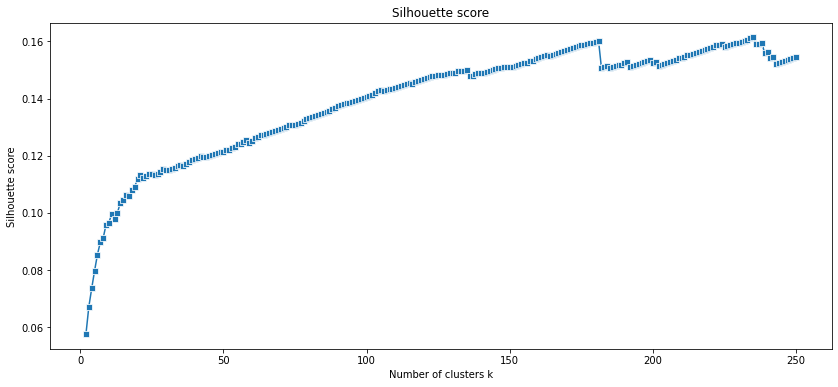

In [221]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [222]:
best_k = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_k

235

In [223]:
%%time
agglomerative = AgglomerativeClustering(n_clusters=best_k)
elon_df['cluster_agglom'] = agglomerative.fit_predict(text_tfidf)

CPU times: user 21.8 s, sys: 160 ms, total: 22 s
Wall time: 21.9 s


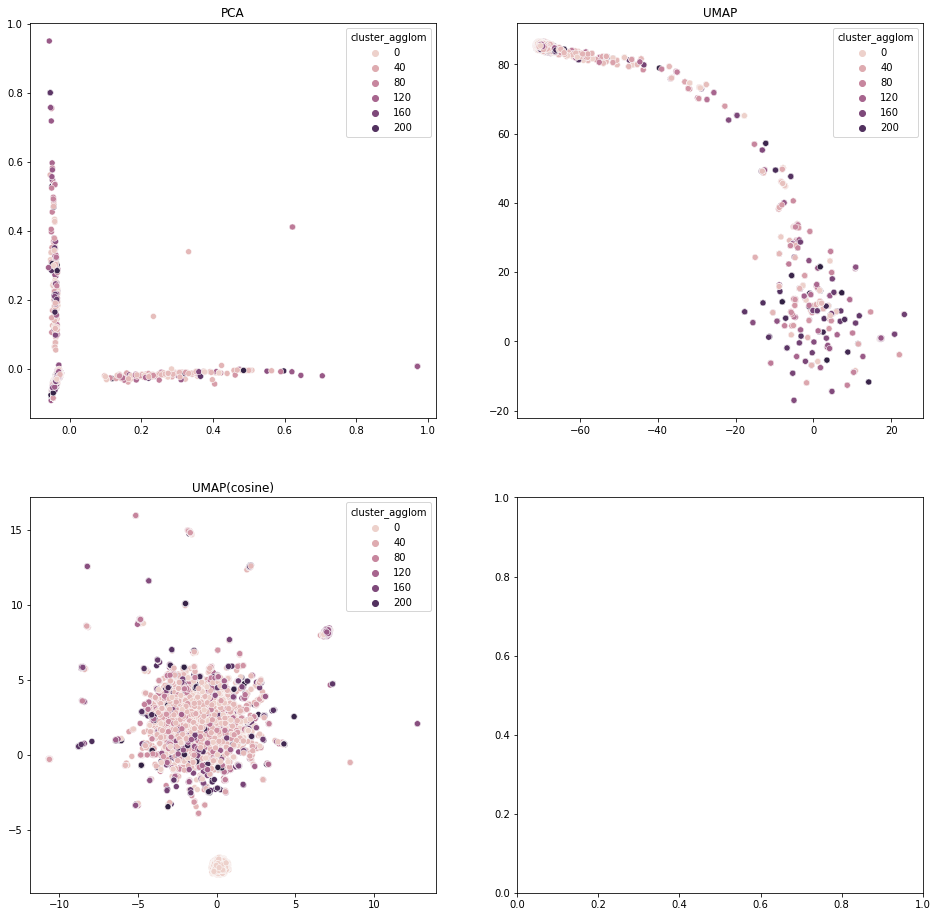

In [224]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['cluster_agglom']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['cluster_agglom']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['cluster_agglom']);

In [225]:
elon_df.groupby('cluster_agglom')['cluster_agglom'].count()

cluster_agglom
0      1209
1        43
2        47
3       255
4        15
       ... 
230       7
231      11
232       8
233       7
234      11
Name: cluster_agglom, Length: 235, dtype: int64

In [226]:
for cluster in set(elon_df['cluster_agglom']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster_agglom == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text, n=3)
    )

Cluster   0.  1209 tweets total. Top-3 words: [('two', 18), ('one', 18), ('new', 18)]
Cluster   1.    43 tweets total. Top-3 words: [('pressure', 27), ('bar', 23), ('test', 22)]
Cluster   2.    47 tweets total. Top-3 words: [('air', 17), ('improvements', 15), ('smart', 11)]
Cluster   3.   255 tweets total. Top-3 words: [('tesla', 101), ('cars', 36), ('car', 33)]
Cluster   4.    15 tweets total. Top-3 words: [('movie', 8), ('dumb', 8), ('us', 2)]
Cluster   5.    63 tweets total. Top-3 words: [('first', 24), ('flights', 18), ('part', 13)]
Cluster   6.    41 tweets total. Top-3 words: [('go', 18), ('wrong', 13), ('quite', 8)]
Cluster   7.    24 tweets total. Top-3 words: [('still', 11), ('mind', 9), ('change', 8)]
Cluster   8.    63 tweets total. Top-3 words: [('fsd', 54), ('beta', 35), ('vision', 28)]
Cluster   9.    30 tweets total. Top-3 words: [('ever', 22), ('best', 15), ('car', 5)]
Cluster  10.    28 tweets total. Top-3 words: [('plaid', 21), ('thing', 10), ('beyond', 8)]
Cluster  1

In [206]:
cluster = 7

print('Entries:', len(elon_df.query(f'cluster_agglom == {cluster}')))
print(print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text))
elon_df.query(f'cluster_agglom == {cluster}').head(10)

Entries: 602
[('starship', 84), ('engine', 73), ('launch', 61), ('raptor', 60), ('booster', 57), ('engines', 50), ('high', 47), ('test', 47), ('landing', 47), ('thrust', 46), ('ship', 41), ('pressure', 41), ('flight', 37), ('rocket', 37), ('texas', 37), ('tons', 32), ('legs', 31), ('spacex', 30), ('dragon', 30), ('fire', 29), ('steel', 28), ('heat', 28), ('bar', 27), ('orbital', 25), ('tank', 25)]


,text,date,datetime,cluster,clusters_dbsacn,cluster_agglom
id,,,,,,
1205676667705757696,@bluemoondance74 @ThugsAndMiracle @tfspeakcies...,2019-12-14,2019-12-14 02:31:32,0,-1,7
1202056276353544192,Launching third flight of this Dragon spacecra...,2019-12-04,2019-12-04 02:45:24,0,-1,7
1199569673832009728,"@jpthor__ @RodAdib1 Yes, Cybertruck will have ...",2019-11-27,2019-11-27 06:04:31,0,-1,7
1198772995021406209,@RodAdib1 Yup. Sledgehammer impact on door cra...,2019-11-25,2019-11-25 01:18:48,0,-1,7
1198751258384818176,Cybertruck pulls F-150 uphill https://t.co/Of...,2019-11-24,2019-11-24 23:52:26,0,25,7
1198702136231526401,@flcnhvy Starship steel decision came first. W...,2019-11-24,2019-11-24 20:37:14,0,-1,7
1198700591465156608,Reason Cybertruck is so planar is that you can...,2019-11-24,2019-11-24 20:31:06,0,-1,7
1198094738739486720,Riding in the Cybertruck,2019-11-23,2019-11-23 04:23:39,0,25,7
1198090787520598016,Franz throws steel ball at Cybertruck window r...,2019-11-23,2019-11-23 04:07:57,0,-1,7
